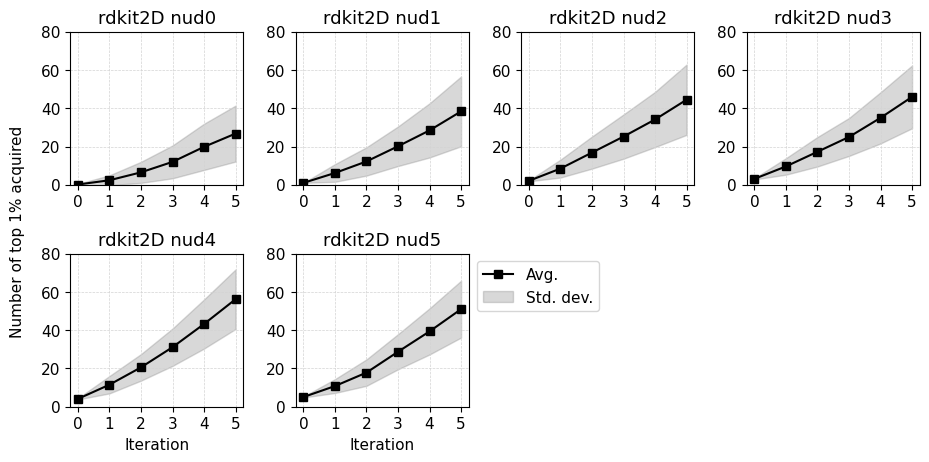

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import math
from matplotlib import cm

def set_dynamic_xticks(ax, max_iterations, desired_ticks=10):
    """
    Dynamically set x-ticks for a given axis.

    Parameters:
    - ax: The axis on which to set the x-ticks.
    - max_iterations: The maximum number of iterations/data points on the x-axis.
    - desired_ticks: The desired maximum number of tick marks on the x-axis (default is 10).
    """
    tick_interval = max_iterations / desired_ticks
    tick_interval = math.ceil(tick_interval)
    ax.set_xticks(np.arange(0, max_iterations + 1, tick_interval))


def format_title(filename):
    # Remove the prefix digits and underscore, and strip off the '.csv' extension
    clean_name = filename.split('_')[1].replace('.csv', '')
    
    # Split the name into model and descriptor parts
    model, descriptor = clean_name.rsplit('-', 1)
    
    # Return the formatted title
    return f'{model}({descriptor})'


def get_data(files):
    data_list = {}
    for file in files:
        data = pd.read_csv(file)
        columns_after_rank = data.columns[3:]
        name = file.split('\\')[-1].split('.')[0]
        for column in columns_after_rank:
            data[column] *= 1320
            pivot_data = data.pivot(index='rank', columns='replicate', values=column)
            pivot_data['Avg.'] = pivot_data.mean(axis=1)
            pivot_data['Std. dev.'] = pivot_data.std(axis=1)
            replicates = len(pivot_data.columns) - 2
            pivot_data['Std. error'] = pivot_data.std(axis=1) / (replicates ** 0.5)
            data_list[name] = pivot_data
    return data_list

def plot_all_graphs(data, graphs_per_row=4):
    """
    Plots graphs for each dataset stored in the data dictionary.

    Parameters:
    - data: Dictionary of dataframes where keys are dataset names.
    - graphs_per_row: Number of graphs to display in each row.
    """
    rows_for_files = int(np.ceil(len(data) / graphs_per_row))
    fig, axes = plt.subplots(rows_for_files, graphs_per_row, figsize=(15, 5 * rows_for_files), squeeze=False)
    
    for i, (dataset_name, pivot_data) in enumerate(data.items()):
        # Determine subplot location
        row, col = divmod(i, graphs_per_row)
        ax = axes[row, col]

        # Plotting logic
        for col in pivot_data.columns[:-2]:  # Ignore the last two columns ('Avg.' and 'Std. dev.')
            ax.plot(pivot_data.index, pivot_data[col], alpha=0.1, marker='o', linestyle='--', label='Individual runs' if col == pivot_data.columns[0] else "")

        ax.plot(pivot_data.index, pivot_data['Avg.'], label='Avg.', color='black', linestyle='-', linewidth=2, marker='s')
        ax.fill_between(pivot_data.index, pivot_data['Avg.'] - pivot_data['Std. dev.'], pivot_data['Avg.'] + pivot_data['Std. dev.'], color='gray', alpha=0.2, label="Std. dev.")

        ax.set_title(dataset_name, fontsize=12)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Number of top 1% acquired')
        ax.set_ylim(0, 100)
        set_dynamic_xticks(ax, int(pivot_data.index.max()))

        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
        if i == len(data) - 1:  # Add legend only to the last plot
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Adjust layout to make room for plot labels and titles
    plt.tight_layout()
    plt.show()


def plot_compact_graphs(data, graphs_per_row=4, dpi=300, title_size=10, label_size=9, tick_size=8, legend_size=7):
    total_plots = len(data)
    rows_for_files = int(np.ceil(total_plots / graphs_per_row))
    fig, axes = plt.subplots(rows_for_files, graphs_per_row, figsize=(10, 2.5 * rows_for_files), dpi=dpi, squeeze=False)
    
    axes = axes.flatten()  # Flatten the axes array for easier indexing
    for i, (dataset_name, pivot_data) in enumerate(data.items()):
        ax = axes[i]
        row, col = divmod(i, graphs_per_row)  # Calculate row and column index for the subplot

        # for col_name in pivot_data.columns[:-2]:
        #     ax.plot(pivot_data.index, pivot_data[col_name], alpha=0.2, marker='o', linestyle='--', label='Individual runs' if col_name == pivot_data.columns[0] else "")

        ax.plot(pivot_data.index, pivot_data['Avg.'], label='Avg.', color='black', linestyle='-', linewidth=1.5, marker='s')
        ax.fill_between(pivot_data.index, pivot_data['Avg.'] - pivot_data['Std. dev.'], pivot_data['Avg.'] + pivot_data['Std. dev.'], color='gray', alpha=0.3, label="Std. dev.")

        ax.set_title(dataset_name, fontsize=title_size)
        
        # Only set the xlabel if the subplot is in the last row
        if row == (rows_for_files - 1):  # Corrected conditional for x-labels
            ax.set_xlabel('Iteration', fontsize=label_size)
        else:
            pass

        ax.set_ylim(0, 80)
        set_dynamic_xticks(ax, int(pivot_data.index.max()))
        ax.tick_params(axis='both', which='major', labelsize=tick_size)

        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
        if i == total_plots - 1:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=legend_size)

    for j in range(total_plots, rows_for_files * graphs_per_row):
        axes[j].axis('off')

    # Set a common y-label for the entire figure
    fig.text(0.04, 0.5, 'Number of top 1% acquired', va='center', rotation='vertical', fontsize=label_size)

    plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15, wspace=0.3, hspace=0.45)
    plt.show()
    
files = glob.glob('**/*.csv', recursive=True)
data = get_data(files)

plot_compact_graphs(data, graphs_per_row=4, dpi=100, title_size=13, label_size=11, tick_size=11, legend_size=11)